*** In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. I am building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. we have data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. ***

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pprint as pp
import numpy as np
import operator
import pandas as pd
from time import time

from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn import grid_search

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [53]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
#lets verify if data is as expected with given features
print 'Number of features: ', len(data_dict[data_dict.keys()[0]].keys())
pp.pprint(data_dict[data_dict.keys()[0]].keys())
print '\n'

Number of features:  21
['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']




** Lets verify quality of data **

In [3]:
#verify total number of enron employees and POIs in data
print 'Total Number of Employees: ', len(data_dict)
poi_count = 0
for key, value in data_dict.items():
    if value['poi'] == True:
        poi_count += 1
    
print 'Total Number of POIs: ', poi_count
#lets verify the data quality
print '*** Data Quality ***'
print 'Feature, [Total Available, Percentage, POIs]'
features_data = {}  # count of number of features having data
features = data_dict[data_dict.keys()[0]].keys()
for feature in features:
    features_data[feature] = [0, 0, 0]
for emp_features in data_dict.values():
    for feature in features:
        if feature in emp_features.keys():
            if feature == 'email_address': 
                if emp_features[feature] != '':
                    features_data[feature][0] += 1
                    if emp_features['poi'] == True:
                        features_data[feature][2] += 1
            elif type(emp_features[feature]) != type('str'):
                features_data[feature][0] += 1
                if emp_features['poi'] == True:
                    features_data[feature][2] += 1
#calculate percentage of employees having data                
for key, value in features_data.items():
    features_data[key][1] = (value[0]*100/len(data_dict))

pp.pprint(sorted(features_data.items(), key=operator.itemgetter(1)))
print '\n'

Total Number of Employees:  146
Total Number of POIs:  18
*** Data Quality ***
Feature, [Total Available, Percentage, POIs]
[('loan_advances', [4, 2, 1]),
 ('director_fees', [17, 11, 0]),
 ('restricted_stock_deferred', [18, 12, 0]),
 ('deferral_payments', [39, 26, 5]),
 ('deferred_income', [49, 33, 11]),
 ('long_term_incentive', [66, 45, 12]),
 ('bonus', [82, 56, 16]),
 ('to_messages', [86, 58, 14]),
 ('shared_receipt_with_poi', [86, 58, 14]),
 ('from_messages', [86, 58, 14]),
 ('from_poi_to_this_person', [86, 58, 14]),
 ('from_this_person_to_poi', [86, 58, 14]),
 ('other', [93, 63, 18]),
 ('salary', [95, 65, 17]),
 ('expenses', [95, 65, 18]),
 ('exercised_stock_options', [102, 69, 12]),
 ('restricted_stock', [110, 75, 17]),
 ('total_payments', [125, 85, 18]),
 ('total_stock_value', [126, 86, 18]),
 ('email_address', [146, 100, 18]),
 ('poi', [146, 100, 18])]




** We have only 12% of employees in data are marked as POI. Lets try to understand if there is any criteria in data by plots. So we can identify what are the best features can be used to train the classifier. **
*** Data not available in 6 features for more than 50% of employees, we will try algorithm later without these features ***

#### Explore data to find if any feature distinguishes POIs
** We have 85% of employees having total payment in data and all 18 POIs have this data. Lets analyse this **

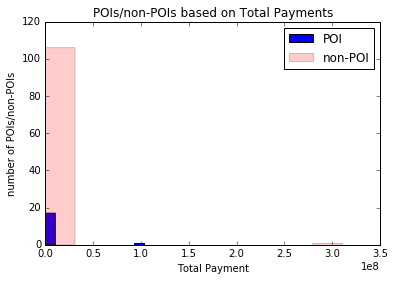

In [4]:
poi_total_payments = []
non_poi_total_payments = []
for key, value in data_dict.items():
    if value['poi'] == True:
        poi_total_payments.append(value['total_payments'])
    else:
        if type(value['total_payments']) <> type('str'):
            non_poi_total_payments.append(value['total_payments'])

plt.hist(poi_total_payments, label='POI')
plt.hist(non_poi_total_payments, color='r', alpha=0.2, label='non-POI')
plt.title("POIs/non-POIs based on Total Payments")
plt.xlabel("Total Payment")
plt.ylabel("number of POIs/non-POIs")
plt.legend()
plt.show()

** We have outliers those are causing data squeezed. Lets plot for data under IQR-Q3 **

In [5]:
payments = []
for key, value in data_dict.items():
    if type(value['total_payments']) <> type('str'): 
        payments.append(value['total_payments'])
                
q75, q25 = np.percentile(payments, [75 ,25])
print 'IQR: ', q75, q25, '\n'

IQR:  2093263.0 394475.0 



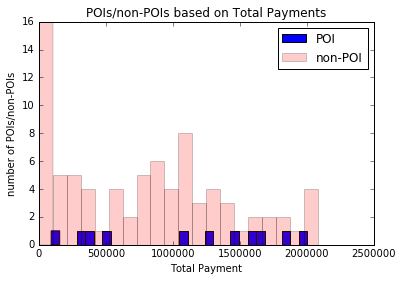

number of POIs under IQR-Q3:  11
number of non-POIs under IQR-Q3:  82

*** Total payment Outliers plot ***


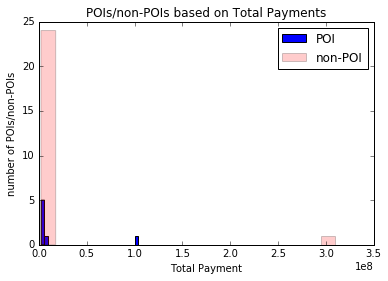

number of POI in Outliers:  7
number of non-POIs in Outliers:  25


In [54]:
#Lets run the histogram again for payments less than Q75
#Do not ignore data under IQR-Q1 now. Lets check how the plot looks at lowest values
poi_total_payments = []
ol_poi_total_payments = []  #outlier data
non_poi_total_payments = []
ol_non_poi_total_payments = []   #outlier data
for key, value in data_dict.items():
    if value['poi'] == True:
        if value['total_payments'] < q75:
            poi_total_payments.append(value['total_payments'])
        else:
            ol_poi_total_payments.append(value['total_payments'])
    else:
        if type(value['total_payments']) <> type('str'):
            if value['total_payments'] < q75:
                non_poi_total_payments.append(value['total_payments'])
            else:
                ol_non_poi_total_payments.append(value['total_payments'])
                
plt.hist(poi_total_payments, label='POI', bins=30)
plt.hist(non_poi_total_payments, color='r', alpha=0.2, label='non-POI', bins=20)
plt.title("POIs/non-POIs based on Total Payments")
plt.xlabel("Total Payment")
plt.ylabel("number of POIs/non-POIs")
plt.legend()
plt.show()

print 'number of POIs under IQR-Q3: ', len(poi_total_payments)
print 'number of non-POIs under IQR-Q3: ', len(non_poi_total_payments)

print '\n', '*** Total payment Outliers plot ***'
plt.hist(ol_poi_total_payments, label='POI', bins=30)
plt.hist(ol_non_poi_total_payments, color='r', alpha=0.2, label='non-POI', bins=20)
plt.title("POIs/non-POIs based on Total Payments")
plt.xlabel("Total Payment")
plt.ylabel("number of POIs/non-POIs")
plt.legend()
plt.show()

print 'number of POI in Outliers: ', len(ol_poi_total_payments)
print 'number of non-POIs in Outliers: ', len(ol_non_poi_total_payments)

*** We do not see any clear distinguishion related to Total Payment between POIs and non POIs. ***  <br>
*** If we look into outlier plot,we have some POIs and non-POIs under 20 mm (aaprx), I would still keep these employees in my data, but lets look at 2 employees having 100mm or more ***

In [7]:
for key, value in data_dict.items():
    if type(value['total_payments']) <> type('str') and value['total_payments'] >= 1e8:
        print key
        pp.pprint(value)
        print '\n'

LAY KENNETH L
{'bonus': 7000000,
 'deferral_payments': 202911,
 'deferred_income': -300000,
 'director_fees': 'NaN',
 'email_address': 'kenneth.lay@enron.com',
 'exercised_stock_options': 34348384,
 'expenses': 99832,
 'from_messages': 36,
 'from_poi_to_this_person': 123,
 'from_this_person_to_poi': 16,
 'loan_advances': 81525000,
 'long_term_incentive': 3600000,
 'other': 10359729,
 'poi': True,
 'restricted_stock': 14761694,
 'restricted_stock_deferred': 'NaN',
 'salary': 1072321,
 'shared_receipt_with_poi': 2411,
 'to_messages': 4273,
 'total_payments': 103559793,
 'total_stock_value': 49110078}


TOTAL
{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False

*** It seems one of the data point is TOTAL, which is not an employee, it does not have email and number of emails too. Lets remove this outlier. *** <br>
*** We have only one person around 100 mm payment, so it is not good idea to train algorithm with such an outlier. We can remove LAY KENNETH from our data ***

In [8]:
#Delete LAY KENNETH L and TOTAL
del data_dict['LAY KENNETH L']
del data_dict['TOTAL']
#check number of employees to make sure only 2 are removed
print 'Number of Employees after Outlier removed: ', len(data_dict), '\n'

Number of Employees after Outlier removed:  144 



** Lets plot percentage of emails between POIs v/s non-POIs to see if there is any criteria for POI **

In [9]:
### create new features
### We do have total number of emails and POI emails (from/to), I would rather use 
### percentage of emails from/to POIs to analyse behaviour. 
### new features are: fraction_to_poi_email,fraction_from_poi_email
### calculate fraction (0 to 1) for percentage

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

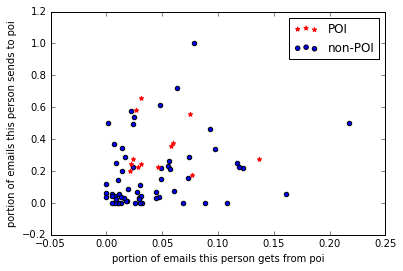

In [10]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0] == 1:
        pl_poi = plt.scatter(from_poi, to_poi, color="r", marker="*")
    else:
        pl_nonPOI = plt.scatter( from_poi, to_poi )
plt.xlabel("portion of emails this person gets from poi")
plt.ylabel("portion of emails this person sends to poi")
plt.legend((pl_poi, pl_nonPOI), ('POI', 'non-POI'))
plt.show()

#### Run supervised learning algorithm
*** we do not really see any behavior above ***
** Lets try decision tree classifier to find important features using feature_importances **
* Important to select test data percentage to have both labels in test data *

In [64]:
def train_test_data(features_):
    data = featureFormat(my_dataset, features_)

    ### split into labels and features (this line assumes that the first
    ### feature in the array is the label, which is why "poi" must always
    ### be first in features_list
    labels, features = targetFeatureSplit(data)

    ### split data into training and testing datasets
    return cross_validation.train_test_split(features, labels, test_size=0.30, random_state=42)

def test_algorithm(clf, features_tr, features_ts):
    t0 = time()
    clf.fit(features_tr,labels_train)
    score = clf.score(features_ts,labels_test)
    pred= clf.predict(features_ts)
    run_time = round(time()-t0, 3)
    #return pred, {'Accuracy':round(score,2), 'Precision':round(precision_score(labels_test, pred), 2), 
    #        'Recall': round(recall_score(labels_test, pred), 2),
    #        'F1_Score': round(f1_score(labels_test, pred), 2), 'Duration_sec': run_time}
    return {'Accuracy':round(score,2), 'Precision':round(precision_score(labels_test, pred), 2), 
            'Recall': round(recall_score(labels_test, pred), 2),
            'F1_Score': round(f1_score(labels_test, pred), 2), 'Duration_sec': run_time}

features_li = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'total_payments', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'shared_receipt_with_poi', 'restricted_stock']
features_train, features_test, labels_train, labels_test = train_test_data(features_li)
print 'Make sure we have approximately equal percentage of POIs in Train and Test out of 18 POIs.'
print 'Test labels: ', labels_test, '\n'    
clf0 = DecisionTreeClassifier()
print '*** Decesiontree Algorithm - features with atleast 50% having data***'
print test_algorithm(clf0,features_train,features_test), '\n'

features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
features_train, features_test, labels_train, labels_test = train_test_data(features_list)
    
clf1 = DecisionTreeClassifier()
print '*** Decesiontree Algorithm with all features ***'
print test_algorithm(clf1,features_train,features_test), '\n'

importances = clf1.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "\t {} {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

Make sure we have approximately equal percentage of POIs in Train and Test out of 18 POIs.
Test labels:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 

*** Decesiontree Algorithm - features with atleast 50% having data***
(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.]), {'F1_Score': 0.55, 'Recall': 0.6, 'Duration_sec': 0.002, 'Precision': 0.5, 'Accuracy': 0.88}) 

*** Decesiontree Algorithm with all features ***
(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,

In [55]:
dump_classifier_and_data(clf0, my_dataset, features_li)

** We have good accuracy and precision with features having more than 50% data (call it 50%Classifier).** <br> 
** Lets try selecting top percentile features and check if we can get same or better result **

In [49]:
def select_features(clf, perc_fea):
    selector = SelectPercentile(f_classif, percentile=perc_fea)
    selector.fit(features_train,labels_train)
    features_train_s = selector.transform(features_train)
    features_test_s = selector.transform(features_test)
    metrics = test_algorithm(clf,features_train_s,features_test_s)
    metrics['Percentile'] = perc_fea
    print metrics, '\n'

selector = SelectPercentile(f_classif, percentile=100)
selector.fit(features_train,labels_train)
print '** Feature scores **'
indices = np.argsort(selector.scores_)[::-1]
for i in range(16):
    print "\t {} {} ({})".format(i+1,features_list[i+1],selector.scores_[indices[i]])

print '\n', '*** Decesiontree Algorithm with Select percentile features ***'
percents = [90, 80, 70, 60, 50, 40, 30, 20, 10]
for percent in percents:
    clf2 = DecisionTreeClassifier()
    select_features(clf2, percent)

** Feature scores **
	 1 salary (10.525999517)
	 2 bonus (9.72671820656)
	 3 fraction_from_poi_email (7.37234089147)
	 4 fraction_to_poi_email (6.729881304)
	 5 deferral_payments (4.19795409263)
	 6 total_payments (3.53704375061)
	 7 loan_advances (3.28883380053)
	 8 restricted_stock_deferred (2.5467282253)
	 9 deferred_income (2.05798427969)
	 10 total_stock_value (1.81982858476)
	 11 expenses (0.656824597561)
	 12 exercised_stock_options (0.613834515306)
	 13 long_term_incentive (0.135172413793)
	 14 shared_receipt_with_poi (0.100841354456)
	 15 restricted_stock (0.0708629130261)
	 16 director_fees (0.0519082529191)

*** Decesiontree Algorithm with Select percentile features ***
{'F1_Score': 0.4, 'Recall': 0.4, 'Precision': 0.4, 'Duration_sec': 0.001, 'Percentile': 90, 'Accuracy': 0.86} 

{'F1_Score': 0.55, 'Recall': 0.6, 'Precision': 0.5, 'Duration_sec': 0.001, 'Percentile': 80, 'Accuracy': 0.88} 

{'F1_Score': 0.5, 'Recall': 0.6, 'Precision': 0.43, 'Duration_sec': 0.001, 'Percentil

** The best metrics available at 50% features and which matches to our 50%Classfier and then metrics start dropping. This is kind of regularization point. We do not have to really consider performance to identify POIs. Anyway I would still go with 50%classifier which relies on features having data ** <br>
*** Lets try naive bayes algorithm and compare result ***

In [50]:
print '\n', '*** Naive Bayes Algorithm with percentile features ***'
percents = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
for percent in percents:
    clf3 = GaussianNB()
    select_features(clf3, percent)


*** Naive Bayes Algorithm with percentile features ***
{'F1_Score': 0.26, 'Recall': 1.0, 'Precision': 0.15, 'Duration_sec': 0.001, 'Percentile': 100, 'Accuracy': 0.33} 

{'F1_Score': 0.26, 'Recall': 1.0, 'Precision': 0.15, 'Duration_sec': 0.002, 'Percentile': 90, 'Accuracy': 0.33} 

{'F1_Score': 0.4, 'Recall': 1.0, 'Precision': 0.25, 'Duration_sec': 0.002, 'Percentile': 80, 'Accuracy': 0.65} 

{'F1_Score': 0.42, 'Recall': 1.0, 'Precision': 0.26, 'Duration_sec': 0.002, 'Percentile': 70, 'Accuracy': 0.67} 

{'F1_Score': 0.44, 'Recall': 0.4, 'Precision': 0.5, 'Duration_sec': 0.002, 'Percentile': 60, 'Accuracy': 0.88} 

{'F1_Score': 0.44, 'Recall': 0.4, 'Precision': 0.5, 'Duration_sec': 0.002, 'Percentile': 50, 'Accuracy': 0.88} 

{'F1_Score': 0.44, 'Recall': 0.4, 'Precision': 0.5, 'Duration_sec': 0.001, 'Percentile': 40, 'Accuracy': 0.88} 

{'F1_Score': 0.44, 'Recall': 0.4, 'Precision': 0.5, 'Duration_sec': 0.001, 'Percentile': 30, 'Accuracy': 0.88} 

{'F1_Score': 0.25, 'Recall': 0.2, 'P

*** All the metrics are too low comparing to Decision Classifier, So using Decision classifier is better choice ***

** Lets try manually selecting payment features **

In [51]:
features_manual = ["poi", "salary", "bonus", 
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'restricted_stock', 'director_fees']
features_train, features_test, labels_train, labels_test = train_test_data(features_manual)

clf4 = DecisionTreeClassifier()
print '*** Decesiontree Algorithm with only payments features ***'
print test_algorithm(clf4,features_train,features_test), '\n'

*** Decesiontree Algorithm with only payments features ***
{'F1_Score': 0.31, 'Recall': 0.4, 'Duration_sec': 0.002, 'Precision': 0.25, 'Accuracy': 0.79} 



** Precision is too low. ** <br> 
*** we are still better with 50%classifier. *** <br>
##### Parameter tuning
** We have run algorithms with default parameters till now, but algorithm might do more accurate fitting for decision surface by changing parameters. ** <br>
*** Lets repeat 50%classifier with different classifier parameters to see if we can achieve better result with any other parameter in algorithm ***

In [52]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'total_payments', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'shared_receipt_with_poi', 'restricted_stock']
features_train, features_test, labels_train, labels_test = train_test_data(features_list)

parameters = {'criterion':('gini', 'entropy')}
dtc = DecisionTreeClassifier()
clf5 = grid_search.GridSearchCV(dtc, parameters)
print 'Run Decesion Tree classifier with GridSearchCV'
print test_algorithm(clf5,features_train,features_test), '\n'


Run Decesion Tree classifier with GridSearchCV
{'F1_Score': 0.25, 'Recall': 0.2, 'Duration_sec': 0.023, 'Precision': 0.33, 'Accuracy': 0.86} 



** The best algorithm here is Decision Tree Classifier with default parameters i.e., 50%Classfier**

### Conclusion
* We got good precision (50%) and Recall (60%). There is 60% of chance that algorithm marks fraudulent as POI and 50% of chance that further investigations will find POIs involvement in scandal.* <br>
* We have run many algorithms to validate supervised learning, but we did that without any target on metrics, Ex: we did not target 99% precision as Google might target in self driving car algorithms. We just did cross validation and chosen better one. My idea is, we should be continuously evaluating algorithms and adjusting as we get more data and more investigations happen on POIs.* <br>
* If employee not marked as POI in my classifier, I will always use another classifier with 50 percentile features to train and predict. The reason is that, employees to be predicted might have little or no communication emails with already marked POIs, but they might have emails with another set of fraudulent employees which are not part of our trained data yet.